VNTCData (https://www.kaggle.com/datasets/aischoolvn/vntcdata) contains 10 article topics Viet Nam NLP.

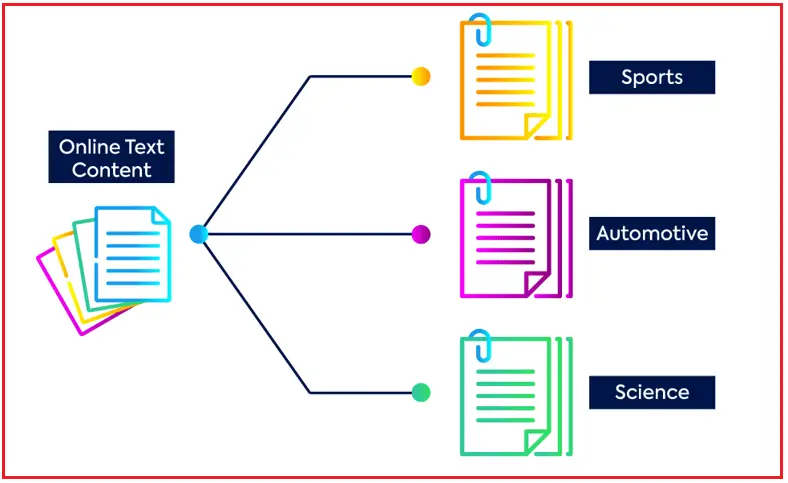

## Step 1: Import Library and Traing Dataset

In [1]:
import json
from tqdm import tqdm
import numpy as np
from keras.preprocessing.text import Tokenizer
import keras
import tensorflow as tf
from keras.utils import pad_sequences
from keras.layers import Embedding, Bidirectional, LSTM, Dense
from sklearn.model_selection import train_test_split

In [2]:
with open('archive/stopwords-nlp-vi.txt') as f:
    stop_word = ['_'.join(word.strip().split()) for word in f.readlines()]

In [3]:
with open("archive/train_dict.json", 'r', encoding = 'utf-16-le') as f:
    datastore = json.load(f)

In [4]:
len_dataset = len(datastore['topic_ids'])
topics = set(datastore['topic_ids'])
n_topics = len(topics)
print('length dataset:', len_dataset)
print('n_topics:', n_topics)
print('topics:', topics)

length dataset: 33759
n_topics: 10
topics: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


## Step 2: Preprocessing dataset

Remove stop word in sentence and split to training set and validation set

In [5]:
sentences = []
labels = []

for sentence, label in tqdm(zip(datastore['contents'], datastore['topic_ids']), total=len_dataset):
    sentence = ' '.join([word for word in sentence if word not in stop_word])
    sentences.append(sentence)
    labels.append(label)

100%|██████████| 33759/33759 [03:26<00:00, 163.17it/s]


In [6]:
training_sentences, testing_sentences, training_labels, testing_labels = train_test_split(sentences, labels,
                                                                                          test_size=0.1, 
                                                                                          shuffle=True,
                                                                                          random_state=123)


In [7]:
[training_labels.count(i) for i in range(n_topics)]

[4695, 2846, 1638, 2314, 3461, 3053, 2614, 4746, 2786, 2230]

In [8]:
[testing_labels.count(i) for i in range(n_topics)]

[524, 313, 182, 238, 407, 331, 284, 552, 294, 251]

In [9]:
words = set()
for sentence in sentences:
    sentence = sentence.split()
    words.update(sentence)
n_vocab = len(words)
n_vocab

117077

In [10]:
max_len = max(len(sentence.split()) for sentence in sentences)
max_len

4991

## Step 3: Tokenizer and Pad Sequences

In [11]:
vocab_size = n_vocab
max_length = 500
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate the word index dictionary
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Convert the labels lists into numpy arrays
training_labels = np.array(training_labels)
testing_labels = np.array(testing_labels)

## Step 4: Build Model Embedding LSTM and Training

In [12]:
# Parameters
embedding_dim = 16
lstm_dim = 32
dense_dim = 16

# Model Definition with LSTM
model_lstm = keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(lstm_dim)),
    Dense(dense_dim, activation='relu'),
    Dense(n_topics, activation='softmax')
])

# Set the training parameters
model_lstm.compile(loss="sparse_categorical_crossentropy",
                   optimizer='adam',
                   metrics=["accuracy"])

# Print the model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 16)           1873232   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               12544     
 l)                                                              
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 10)                170       
                                                                 
Total params: 1,886,986
Trainable params: 1,886,986
Non-trainable params: 0
_________________________________________________________________


In [13]:
def scheduler(epoch, lr):
    return lr * 10**-tf.math.floor(epoch/5)

In [14]:
NUM_EPOCHS = 10
BATCH_SIZE = 32
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
my_callbacks = [lr_scheduler, early_stop]
# Train the model
history_lstm = model_lstm.fit(training_padded, training_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                              validation_data=(testing_padded, testing_labels),
                              callbacks=my_callbacks)

Epoch 1/10
950/950 [==============================] - 111s 94ms/step - loss: 1.5855 - accuracy: 0.4031 - val_loss: 1.1076 - val_accuracy: 0.6126 - lr: 0.0010
Epoch 2/10
950/950 [==============================] - 83s 87ms/step - loss: 0.8893 - accuracy: 0.6993 - val_loss: 0.7053 - val_accuracy: 0.7784 - lr: 0.0010
Epoch 3/10
950/950 [==============================] - 83s 87ms/step - loss: 0.5291 - accuracy: 0.8385 - val_loss: 0.5314 - val_accuracy: 0.8409 - lr: 0.0010
Epoch 4/10
950/950 [==============================] - 83s 87ms/step - loss: 0.3608 - accuracy: 0.8931 - val_loss: 0.5278 - val_accuracy: 0.8480 - lr: 0.0010
Epoch 5/10
950/950 [==============================] - 83s 87ms/step - loss: 0.2815 - accuracy: 0.9174 - val_loss: 0.5658 - val_accuracy: 0.8495 - lr: 0.0010
Epoch 6/10
950/950 [==============================] - 84s 88ms/step - loss: 0.1762 - accuracy: 0.9507 - val_loss: 0.5384 - val_accuracy: 0.8569 - lr: 1.0000e-04
Epoch 7/10
950/950 [==============================] -

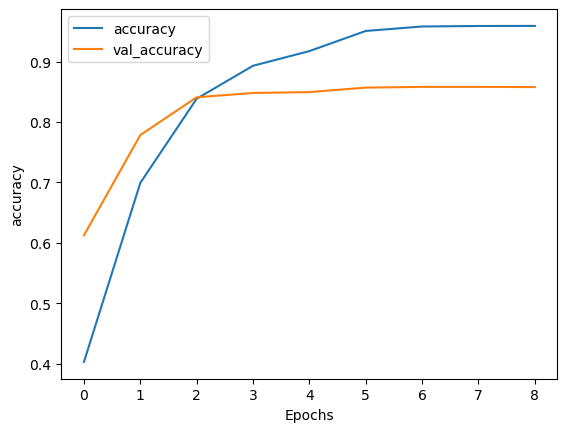

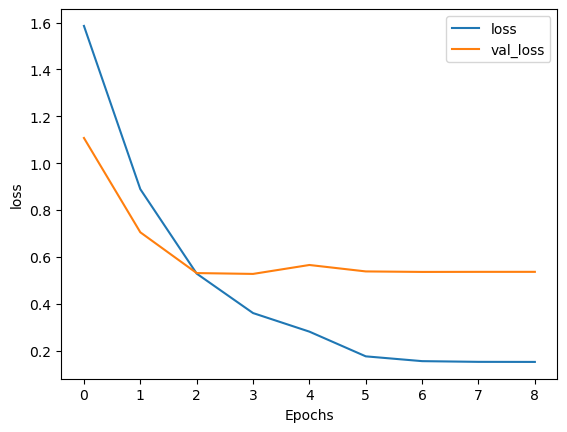

In [15]:
import matplotlib.pyplot as plt

# Plot Utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

# Plot the accuracy and loss history
plot_graphs(history_lstm, 'accuracy')
plot_graphs(history_lstm, 'loss')

In [16]:
model_lstm.save('my_model.h5')

In [17]:
import pickle

# saving the Tokenizer class
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)